# mapping the ICU rainfall forecast

In [1]:
%matplotlib inline

In [2]:
import os
import sys
import pathlib

In [3]:
import numpy as np
import pandas as pd

import geopandas as gpd

import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
import cartopy.io.shapereader as shpreader

import matplotlib.pyplot as plt
from matplotlib import patheffects
from matplotlib.transforms import offset_copy

### loads the local functions

In [4]:
sys.path.append(str(pathlib.Path.cwd().parent))

In [5]:
from lib import *

### bulletin directory 

In [6]:
bulletin_dir = 'MJJ_2019'

### season

In [7]:
season = 'May - Jul.'

### project folder on the project drive 

In [8]:
if not (pathlib.Path.home() / 'drives' / 'auck_projects' / 'ICU14101' / 'Working' / bulletin_dir).exists(): 
    (pathlib.Path.home() / 'drives' / 'auck_projects' / 'ICU14101' / 'Working' / bulletin_dir).mkdir(parents=True)

### defines the path to the shapefiles 

In [9]:
shapes_path = pathlib.Path.cwd().parents[1] / 'data' / 'shapefiles' / 'ICU' / 'all_ICU_countries'

### build dictionnary with level: colors for mapping of rainfall forecasts 

In [10]:
outlook_rgb = [[131, 180, 215], [216, 241, 255], [237, 237, 237], [255, 236, 228], [235, 129, 125], [140, 140, 140]]

In [11]:
outlook_rgb = [rgb2hex(*x) for x in outlook_rgb]

In [12]:
outlook_rgb = dict(zip([4, 2, 0, -3, -5, -666], outlook_rgb))

### set crs here 

**NOTE**: potential problems with the Mercator projection might be due to the version of `proj4` that is used

In [13]:
extent = [125, -120, -32, 25]

In [14]:
crs = ccrs.Mercator(central_longitude=180., latitude_true_scale=0., min_latitude=extent[-2], max_latitude=extent[-1])

In [15]:
# crs = ccrs.PlateCarree(central_longitude=180)

### read the shapefile with the ICU EEZ geometries

In [16]:
shapes_path = pathlib.Path.cwd().parents[1] / 'data' / 'shapefiles' / 'ICU' / 'all_ICU_countries'

In [17]:
shape_gpd = gpd.read_file(shapes_path / 'ALL_ICU_countries.shp')

In [18]:
shape_gpd = shape_gpd.loc[:,['COUNTRYNAM','geometry']]

In [19]:
lons_lats = {}
for i, row in shape_gpd.iterrows():
    geom = row.geometry
    x = geom.centroid.xy[0][0]
    y = geom.centroid.xy[1][0]
    lons_lats[row.COUNTRYNAM] = np.array([x, y]) 
lons_lats = pd.DataFrame(lons_lats).T
lons_lats.columns = ['lon','lat']

In [20]:
shape_gpd.set_index('COUNTRYNAM', drop=False, inplace=True)

In [21]:
shape_gpd.loc[:,'name_to_plot'] = shape_gpd.loc[:,'COUNTRYNAM']

In [22]:
shape_gpd = shape_gpd.merge(lons_lats, left_index=True, right_index=True)

In [23]:
shape_gpd.tail()

,COUNTRYNAM,geometry,name_to_plot,lon,lat
Northern Marianas,Northern Marianas,"POLYGON ((142.130214 15.621139, 142.2 15.91558...",Northern Marianas,145.787063,18.242864
Marshall Islands,Marshall Islands,"POLYGON ((168.5875 1.767222, 168.289595 1.8735...",Marshall Islands,167.498711,10.119736
Nauru,Nauru,"POLYGON ((167.823425 -3.76847, 167.8081 -3.771...",Nauru,166.123609,-0.575436
Palau,Palau,"POLYGON ((134.615853 3.445384, 133.925946 3.02...",Palau,133.069028,6.360811
American Samoa,American Samoa,"(POLYGON ((-171.309843 -16.844947, -171.496166...",American Samoa,-169.057020,-13.860065


### some changes to the lat and lon position of the Island Group name in the map to avoid overlaps 

In [24]:
shape_gpd.loc['Fiji','lon'] = 181

shape_gpd.loc['Tuvalu','lon'] = 180

shape_gpd.loc['Tuamotu / Gambier Islands','lon'] = shape_gpd.loc['Tuamotu / Gambier Islands','lon'] + 2

shape_gpd.loc['Kiribati: Gilbert Islands','lon'] = shape_gpd.loc['Kiribati: Gilbert Islands','lon'] + 2

shape_gpd.loc['Wallis & Futuna','lon'] = shape_gpd.loc['Wallis & Futuna','lon'] -3
shape_gpd.loc['Wallis & Futuna','lat'] = shape_gpd.loc['Wallis & Futuna','lat'] + 1

shape_gpd.loc['American Samoa','lon'] = shape_gpd.loc['American Samoa','lon'] + 2
shape_gpd.loc['American Samoa','lat'] = shape_gpd.loc['American Samoa','lat'] + 1

shape_gpd.loc['Samoa','lat'] = shape_gpd.loc['Samoa','lat'] - 1

shape_gpd.loc['Nauru','lat'] = shape_gpd.loc['Nauru','lat'] - 1

shape_gpd.loc['Southern Cook Islands','lat'] = shape_gpd.loc['Southern Cook Islands','lat'] - 1

shape_gpd.loc['Tonga','lon'] = shape_gpd.loc['Tonga','lon'] + 1

### reads the table containing the rainfall forecasts 

### do not forget to set the climatological forecasts to -666 in the below CSV BEFORE loading it in this notebook

In [25]:
pathlib.Path.cwd().parents[1] / 'bulletin' / bulletin_dir

PosixPath('/home/nicolasf/operational/ICU/ops/bulletin/MJJ_2019')

In [26]:
table = pd.read_csv(pathlib.Path.cwd().parents[1] / 'bulletin' / bulletin_dir / 'ICU_forecast_table_for_mapping.csv')

In [27]:
table.head()

,Unnamed: 0,Stress,COUNTRYNAM
0,Kiribati: Gilbert Islands,4,Kiribati: Gilbert Islands
1,Nauru,4,Nauru
2,Kiribati: Phoenix Islands,4,Kiribati: Phoenix Islands
3,Kiribati: Line Islands,4,Kiribati: Line Islands
4,Tuvalu,4,Tuvalu


In [28]:
table = table.set_index('COUNTRYNAM', drop=False)

In [29]:
table = table.iloc[:,1:]

In [30]:
shape_gpd.head()

,COUNTRYNAM,geometry,name_to_plot,lon,lat
New Caledonia,New Caledonia,"POLYGON ((158.6108 -25.14667, 157.8011 -23.248...",New Caledonia,163.075425,-20.864542
Pitcairn Islands,Pitcairn Islands,"POLYGON ((-132.499382 -22.511733, -132.228513 ...",Pitcairn Islands,-127.470494,-24.568268
Papua New Guinea,Papua New Guinea,"POLYGON ((157.168058 -13.692712, 157.038334 -1...",Papua New Guinea,149.829278,-5.626700
Solomon Islands,Solomon Islands,"POLYGON ((173.5906 -11.85417, 173.525754 -12.5...",Solomon Islands,163.613350,-10.031313
Kiribati: Phoenix Islands,Kiribati: Phoenix Islands,"POLYGON ((-168.921636 -6.882211000000032, -170...",Kiribati: Phoenix Islands,-172.445006,-3.731197


In [31]:
table.index.name = 'locationID'

In [32]:
shape_gpd_m = shape_gpd.merge(table, on='COUNTRYNAM')

In [33]:
year = bulletin_dir.split('_')[-1]

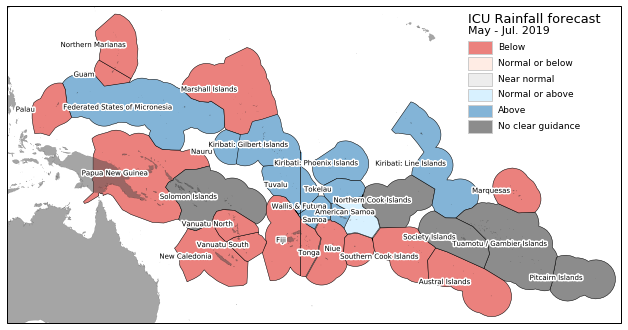

In [34]:
f, ax = plt.subplots(figsize=(11, 8), subplot_kw=dict(projection=crs))

make_choropleth(ax, shape_gpd_m, dict_colors=outlook_rgb)

draw_Pacific(ax, extent = extent)

transform = ccrs.PlateCarree()._as_mpl_transform(ax)

text_transform = offset_copy(transform, units='dots', x=-25)

for i, row in shape_gpd.iterrows(): 
    cname = row.name_to_plot
    lon = row.lon
    lat = row.lat
    txt = ax.text(lon, lat, cname, color='k', verticalalignment='center', horizontalalignment='center',
                 transform=text_transform, fontsize=7)
    txt.set_path_effects([patheffects.withStroke(linewidth=3, foreground='w')])

make_legend_outlook(ax, facecolors=outlook_rgb, subtitle = '{} {}'.format(season, year), fontsize=8.5)

# ax.axvline(180, color='0.8', lw=0.5)

# f.tight_layout()

ax.set_extent([125, 360-120, -32, 25], crs=ccrs.PlateCarree())

f.savefig(pathlib.Path.cwd().parents[1] / 'bulletin' / bulletin_dir / 'ICU_rainfall_forecast_map_{}.png'.format(bulletin_dir), bbox_inches='tight', dpi=200)

### formatting and saving to GeoJSON for the Clidesc Portal

In [ ]:
if not (pathlib.Path.cwd().parent / 'geojsons').exists(): 
    (pathlib.Path.cwd().parent / 'geojsons').mkdir()

In [35]:
shape_gpd_m = shape_gpd_m.rename({'Stress':'Forecast'}, axis=1)

In [36]:
shape_gpd_m.loc[:,'Color'] = shape_gpd_m.loc[:,'Forecast']

In [37]:
shape_gpd_m = shape_gpd_m.replace({'Color':outlook_rgb})

In [38]:
shape_gpd_m.loc[:,'Forecast_season'] = bulletin_dir

In [ ]:
with open(pathlib.Path.cwd().parent / 'geojsons' / 'ICU_rainfall_forecast_latest.geojson', 'w') as f:
    f.write(shape_gpd_m.to_json())